In [1]:
#!/usr/bin/python3
# -*- coding:utf-8 -*-

import itertools
import os
import pathlib
import random
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt, image as mpimg
import pandas as pd
from difficulty_levels import DifficultyLevels
from tensorflow import keras
import tensorflow as tf
from typing import Optional
from tensorflow.python.keras.callbacks import ModelCheckpoint
from einops import rearrange


download_folder = "tracking_data_download"
labeled_images_folder = "labeled_images"

RANDOM_SEED = 42
NUMBER_OF_CLASSES = 3

results_folder = "ml_results"
data_folder_path = os.path.join("..", "post_processing", download_folder)
# print(data_folder_path)

NEW_IMAGE_SIZE = (128, 128)

In [2]:
def split_train_test(participant_list, train_ratio=0.8):
    random.shuffle(participant_list)

    train_split = int(len(participant_list) * train_ratio)
    train_participants = participant_list[:train_split]
    test_participants = participant_list[train_split:]
    print(f"{len(train_participants)} participants used for training: {train_participants}")
    print(f"{len(test_participants)} participants used for validation: {test_participants}")

    return train_participants, test_participants

In [3]:
def set_random_seed(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
def show_result_plot(train_history, epochs, metric="categorical_accuracy", output_folder=results_folder,
                     output_name="train_history.png"):

    acc = train_history.history[f"{metric}"]
    val_acc = train_history.history[f"val_{metric}"]
    loss = train_history.history["loss"]
    val_loss = train_history.history["val_loss"]

    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # save plot to file and show in a new window
    plt.savefig(os.path.join(output_folder, output_name))
    plt.show()

In [5]:
class DifficultyImageClassifier:
    """
    Custom CNN for predicting the difficulty level with images of a user's face.
    """

    def __init__(self, num_classes, num_epochs=32):
        self.n_classes = num_classes
        self.n_epochs = num_epochs
        self.num_workers = 8

    def build_model(self, input_shape: tuple[Optional[int], int, int, int]) -> tf.keras.Model:
        self.sequential_model = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

                tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

                tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=512, activation="relu"),
                tf.keras.layers.Dropout(0.3),

                # units must be the number of classes -> we want a vector that looks like this: [0.2, 0.5, 0.3]
                tf.keras.layers.Dense(units=self.n_classes, activation="softmax")
            ]
        )

        self.sequential_model.summary()
        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])

        return self.sequential_model


    def log_custom_generator_info_before(self, batch, logs):
        print("\nBefore batch: ", batch)
        print("Index list len:", len(self.train_generator.indices_list))
        print(f"get item index: {self.train_generator.get_item_index}")

    def log_custom_generator_info_after(self, batch, logs):
        print("\nAfter batch: ", batch)
        print("Index list len:", len(self.train_generator.indices_list))
        print(f"get item index: {self.train_generator.get_item_index}")

    def train_classifier(self, train_generator, val_generator):
        self.train_generator = train_generator
        self.validation_generator = val_generator

        #self.step_size_train = train_generator.n // (train_generator.sample_size * train_generator.batch_size)
        #self.step_size_val = val_generator.n // (val_generator.sample_size * val_generator.batch_size)

        model_name = "Difficulty-CNN-Model-Generator-Ipynb-Version.h5"
        model_path = os.path.join(results_folder, model_name)

        checkpoint_path = os.path.join(results_folder, "checkpoints_generator",
                                       "checkpoint-improvement-{epoch:02d}-{val_categorical_accuracy:.3f}.ckpt")
        # save checkpoints
        checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_categorical_accuracy', verbose=1,
                                              mode="max", save_best_only=True, save_weights_only=True)
        lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

        # define a custom callback
        custom_callback = tf.keras.callbacks.LambdaCallback(
            on_batch_begin=self.log_custom_generator_info_before, on_batch_end=self.log_custom_generator_info_after)

        history = self.sequential_model.fit(self.train_generator,
                                            #steps_per_epoch=self.step_size_train,
                                            validation_data=self.validation_generator,
                                            #validation_steps=self.step_size_val,
                                            # shuffle=False,
                                            use_multiprocessing=False,
                                            workers=self.num_workers,
                                            #max_queue_size=1,
                                            epochs=self.n_epochs,
                                            callbacks=[checkpoint_callback, lr_callback],  # custom_callback],
                                            verbose=1)

        # self.sequential_model.save(model_path)
        show_result_plot(history, self.n_epochs, metric="categorical_accuracy",
                         output_name="train_history_custom_generator.png")

        return history

    def evaluate_classifier(self):
        val_loss, val_acc = self.sequential_model.evaluate(self.validation_generator,
                                                           #steps=self.step_size_val,
                                                           verbose=1)
        print("Validation loss: ", val_loss)
        print("Validation accuracy: ", val_acc * 100)

In [6]:
def merge_participant_image_logs(participant_list):
    image_data_frame = pd.DataFrame()
    post_processing_folder_path = os.path.join("..", "post_processing")

    for participant in participant_list:
        images_label_log = os.path.join(post_processing_folder_path,  download_folder, participant, "labeled_images.csv")
        # images_label_log = os.path.join(post_processing_folder_path, download_folder, participant, "labeled_eye_regions.csv")
        labeled_images_df = pd.read_csv(images_label_log)

        difficulty_level_df = pd.DataFrame()
        for difficulty_level in labeled_images_df.difficulty.unique():
            # create a subset of the df that contains only the rows with this difficulty level
            sub_df = labeled_images_df[labeled_images_df.difficulty == difficulty_level]
            sub_df = sub_df[:150]
            difficulty_level_df = pd.concat([difficulty_level_df, sub_df])

        image_data_frame = pd.concat([image_data_frame, difficulty_level_df])

    # add the index numbers as own column (reset the index first as the concatenate above creates duplicate indexes)
    image_data_frame_numbered = image_data_frame.reset_index(drop=True)
    image_data_frame_numbered["index"] = image_data_frame_numbered.index

    return image_data_frame_numbered

In [7]:
class CustomImageDataGenerator(tf.keras.utils.Sequence):
    """
    Structure based on https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """

    def __init__(self, data_frame, x_col_name, y_col_name, sample_size, batch_size, num_classes=3,
                 images_base_path=".", use_grayscale=False):

        self.df = data_frame.copy()
        self.X_col = x_col_name
        self.y_col = y_col_name
        self.batch_size = batch_size
        self.sample_size = sample_size
        self.n_classes = num_classes
        self.images_base_path = images_base_path
        self.use_grayscale = use_grayscale

        self.n = len(self.df)
        self.get_item_index = -1

        num_channels = 1 if self.use_grayscale else 3
        self.output_size = (*NEW_IMAGE_SIZE, num_channels)

        # create a random order for the samples
        self.indices_list = self.generate_random_index_list()

    def generate_random_index_list(self):
        sample_indices = []
        for i in range(0, self.n, self.sample_size):
            sample_indices.append(i)

        random.shuffle(sample_indices)
        return sample_indices

    def __len__(self):
        length = self.n // (self.sample_size * self.batch_size)
        return length

    def on_epoch_end(self):
        self.indices_list = self.generate_random_index_list()  # each epoch we generate a new indices order
        
    """
    def __getitem__(self, index):
        self.get_item_index = index

        X = np.empty((self.batch_size, self.sample_size, *self.output_size))
        y = np.empty((self.batch_size, self.n_classes))
        
        if len(self.indices_list) < self.batch_size:
            print(f"\nself.indices_list is empty in __get_item__()!")
            self.indices_list = self.generate_random_index_list()

        indices = random.sample(self.indices_list, k=self.batch_size)
        
        for i, start_index in enumerate(indices):
            sample_rows = self.df[start_index:start_index + self.sample_size]
            image_sample, sample_label = self.__get_data(sample_rows)

            X[i, ] = image_sample
            y[i, ] = sample_label

        # for einops, see https://github.com/arogozhnikov/einops/blob/master/docs/1-einops-basics.ipynb

        #print(X.shape)
        reshaped_X = rearrange(X, 'b1 b2 h w c -> b1 h (b2 w) c')
        # reshaped_X = rearrange(X, 'b1 b2 h w c -> b1 (b2 h) w c')
        #print(reshaped_X.shape)
        
        self.indices_list = [idx for idx in self.indices_list if idx not in set(indices)] 

        return reshaped_X, y
    """
    def __getitem__(self, index):
        self.get_item_index = index

        X = np.empty((self.batch_size, self.sample_size, *self.output_size))
        y = np.empty((self.batch_size, self.n_classes))
        
        # start from the current batch and take the next 'batch_size' indices
        current_index = index * self.batch_size
        indices = self.indices_list[current_index:current_index + self.batch_size]

        for i, start_index in enumerate(indices):
            # Take all elements starting from the current index until the start of the next index
            sample_rows = self.df[start_index:start_index + self.sample_size]
            image_sample, sample_label = self.__get_data(sample_rows)

            X[i, ] = image_sample
            y[i, ] = sample_label

        # for einops, see https://github.com/arogozhnikov/einops/blob/master/docs/1-einops-basics.ipynb

        #print(X.shape)
        reshaped_X = rearrange(X, 'b1 b2 h w c -> b1 h (b2 w) c')
        # reshaped_X = rearrange(X, 'b1 b2 h w c -> b1 (b2 h) w c')
        #print(reshaped_X.shape) 

        return reshaped_X, y


    def __get_data(self, sample):
        image_sample = np.empty((self.sample_size, *self.output_size))

        # Load and preprocess the images for the current sample
        i = 0
        for idx, row in sample.iterrows():
            img_path = row[self.X_col]
            image_path = os.path.join(self.images_base_path, img_path)
            image_sample[i, ] = self.__scale_and_convert_image(image_path)  # load image and resize and scale it
            i += 1

        label = sample[self.y_col].iloc[0]  # take the label of the first element in the sample
        sample_label = DifficultyLevels.get_one_hot_encoding(label)  # convert string label to one-hot-vector

        return image_sample, sample_label


    def __scale_and_convert_image(self, image_path):
        try:
            color_mode = "grayscale" if self.use_grayscale else "rgb"

            image = tf.keras.preprocessing.image.load_img(image_path, color_mode=color_mode)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            # TODO
            # image_arr = tf.image.convert_image_dtype(image_arr, tf.float32)

            # crop or pad image depending on it's size
            resized_img = tf.image.resize_with_crop_or_pad(image_arr,
                                                           target_height=NEW_IMAGE_SIZE[0],
                                                           target_width=NEW_IMAGE_SIZE[1])

            # normalize pixel values to [0, 1] so the ml model can work with smaller values
            scaled_img = resized_img.numpy() / 255.0
            return scaled_img

        except Exception as e:
            sys.stderr.write(f"\nError in processing image '{image_path}': {e}")
            return None

    def get_original_image_shape(self):
        return self.output_size
    
    def get_reshaped_image_shape(self):
        new_image_shape = (self.output_size[0], (self.sample_size * self.output_size[1]), self.output_size[2])
        return new_image_shape
    
    def get_example_batch(self):
        # we need to make a copy first so we don't actually change the list by taking an example
        indices_copy = self.indices_list.copy()
        first_sample, labels = self.__getitem__(0)
        self.indices_list = indices_copy
        return first_sample, labels

In [8]:
def show_generator_example_images_gen_v2(sample, labels):
    sample_len = len(sample)
    length = min(100, sample_len)  # show 100 images or sample length if samples has less images

    plt.figure(figsize=(40, 40))
    for i in range(length):
        plt.subplot(10, 10, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        # plt.imshow(sample[i][0:500, :, :])
        plt.imshow(sample[i][:, 0:500, :])  # if width instead of height 
        plt.title(DifficultyLevels.get_label_for_encoding(labels[i]))
    plt.show()

In [9]:
def start_preprocessing():
    set_random_seed()  # set seed for reproducibility

    """
    without_participants = ["participant_1", "participant_2", "participant_4", "participant_5", "participant_6",
                            "participant_7", "participant_8", "participant_9", "participant_11", "participant_12",
                            "participant_13"]
    """
    without_participants = []
    all_participants = os.listdir(data_folder_path)[:12]
    all_participants = [p for p in all_participants if p not in set(without_participants)]

    train_participants, test_participants = split_train_test(all_participants)

    train_data = merge_participant_image_logs(train_participants)
    val_data = merge_participant_image_logs(test_participants)

    # See https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network for consequences of
    # the batch size. Smaller batches lead to better results in general. Batch sizes are usually a power of two.
    batch_size = 4
    sample_size = 10
    train_epochs = 17
    use_gray = False
    
    print(f"Train Data len: {len(train_data)})")
    print(f"Validation Data len: {len(val_data)})")

    images_path = os.path.join("..", "post_processing")

    train_generator = CustomImageDataGenerator(data_frame=train_data, x_col_name="image_path", y_col_name="difficulty",
                                               sample_size=sample_size, batch_size=batch_size,
                                               images_base_path=images_path, use_grayscale=use_gray)

    val_generator = CustomImageDataGenerator(data_frame=val_data, x_col_name="image_path", y_col_name="difficulty",
                                             sample_size=sample_size, batch_size=batch_size,
                                             images_base_path=images_path, use_grayscale=use_gray)

    # show some example train images to verify the generator is working correctly
    sample, sample_labels = train_generator.get_example_batch()
    show_generator_example_images_gen_v2(sample, sample_labels)

    print("Len train generator: ", train_generator.__len__())
    print("Len val generator: ", val_generator.__len__())

    image_shape = train_generator.get_original_image_shape()
    print("Image Shape: ", image_shape)
    
    reshaped_image_shape = train_generator.get_reshaped_image_shape()
    print("Reshaped Image Shape: ", reshaped_image_shape)

    classifier = DifficultyImageClassifier(num_classes=NUMBER_OF_CLASSES, num_epochs=train_epochs)

    classifier.build_model(input_shape=reshaped_image_shape)
    classifier.train_classifier(train_generator, val_generator)
    classifier.evaluate_classifier()

9 participants used for training: ['participant_16', 'participant_14', 'participant_11', 'participant_2', 'participant_3', 'participant_15', 'participant_5', 'participant_12', 'participant_13']
3 participants used for validation: ['participant_1', 'participant_10', 'participant_4']
Train Data len: 4050)
Validation Data len: 1350)


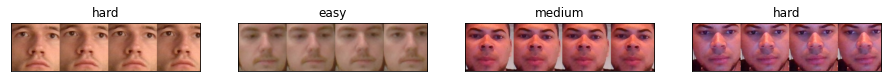

Len train generator:  101
Len val generator:  33
Image Shape:  (128, 128, 3)
Reshaped Image Shape:  (128, 1280, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 1278, 32)     896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 639, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 637, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 318, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 316, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 158, 128)      0         
_______

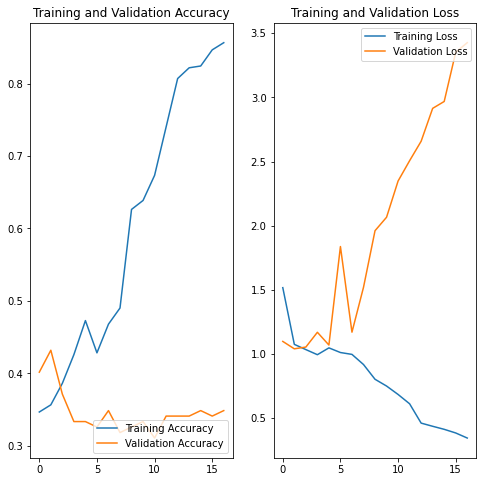

33/33 [==============================] - 6s 169ms/step - loss: 3.4779 - categorical_accuracy: 0.3409
Validation loss:  3.477888822555542
Validation accuracy:  34.090909361839294


In [10]:
start_preprocessing()